In [3]:
%set_env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)

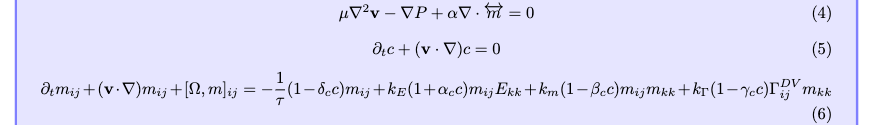

\begin{equation}
    \partial_t \mathbf{v} = \mu \nabla^2 \mathbf{v} - \nabla P + \alpha \nabla \cdot  \overleftrightarrow{m}
    \label{eq:stokes}
\end{equation}

\begin{equation}
    \partial_t c + (\mathbf{v} \cdot \nabla) c = 0
    \label{eq:cadherinadvection}
\end{equation}

\begin{equation}
    \partial_t m_{ij} + (\mathbf{v} \cdot \nabla) m_{ij} + [\Omega, m]_{ij} = 
    -\frac{1}{\tau} (1 - \delta_c c) m_{ij} + 
    k_E (1 + \alpha_c c) m_{ij} E_{kk} + 
    k_m (1 - \beta_c c) m_{ij} m_{kk} + 
    k_{\Gamma} (1 - \gamma_c) \Gamma_{ij}^{DV} m_{kk}
    \label{eq:myosinmodel}
\end{equation}

We have roughly that \tau  = 15, k_E = 0.5, k_m = 0.5, and k_{\Gamma} = 0.05. \alpha, \beta, and \gamma are all approx 0.8. You are correct that the \gamma_c term should be multiplied by c. I’ve realized that Equation (6) in the text is not quite up to date: the detachment is also cadherin-modulated in the latest version of the code. It should look something like below, with \delta~0.8

In [5]:
def get_g_with_scales(field, scales):
    f = field.copy()
    f.change_scales(scales)
    return f["g"]

def simu(params, set_initial_conditions, logger):
    # params: dict containing all parameters
    # initial_conditions: function (dist, (xbasis, ybasis), c, v, m) -> None that should modify the [d3.Field]s c,v,m
    # logger: logging.Logger
    Lx, Ly = params["Lx"], params["Ly"]
    Nx, Ny = params["Nx"], params["Ny"]
    dealias = 3/2
    stop_sim_time = params["max_time"]
    timestepper = d3.SBDF2
    timestep = params["timestep"]
    dtype = np.float64
    
    mu = params["mu"]
    α  = params["α"]
    τ  = params["τ"]
    kE = params["kE"]
    km = params["km"]
    αc = params["αc"]
    βc = params["βc"]
    δc = params["δc"]
    kΓ = params["kΓ"]
    γc = params["γc"]
    Dc = params["Dc"]
    Dm = params["Dm"]

    # Bases
    coords = d3.CartesianCoordinates("x", "y")
    dist = d3.Distributor(coords, dtype=dtype)
    xbasis = d3.RealFourier(coords["x"], size=Nx, bounds=(-Lx/2,Lx/2), dealias=dealias)
    ybasis = d3.RealFourier(coords["y"], size=Ny, bounds=(-Ly/2, Ly/2), dealias=dealias)

    # Fields
    c = dist.ScalarField(name='c', bases=(xbasis,ybasis))
    v = dist.VectorField(coords, name="v", bases=(xbasis,ybasis))
    m = dist.TensorField(coords, name="m", bases=(xbasis, ybasis))
    p = dist.Field(name='p', bases=(xbasis,ybasis))
    tau_p = dist.Field(name='tau_p')

    LCϵ = dist.TensorField(coords, name="ϵ", bases=())
    LCε["g"][:,:,0,0] = np.array([[0,1],[-1,0]])
    Ω = d3.div(d3.skew(v)) * LCϵ

    ΓDV = dist.TensorField(coords, name="ΓDV", bases=())
    ΓDV["g"][:,:,0,0] = np.array([[0,0],[0,1]])

    # Substitutions
    #x, y = dist.local_grids(xbasis, ybasis)
    #ex, ey = coords.unit_vector_fields(dist)

    # Problem
    problem = d3.IVP([c, m, v, p, tau_p], namespace=locals())
    problem.add_equation("dt(c) - Dc*lap(c) = - v@grad(c)")
    problem.add_equation("dt(v) + grad(p) - mu*lap(v) - α * div(m) = 0")# = - v@grad(v)")
    problem.add_equation("div(v) + tau_p = 0")
    problem.add_equation("integ(p) = 0")
    problem.add_equation("dt(m) - Dm*lap(m) + 1/τ * m = 1/τ*δc * c*m - (Ω @ m - m @ Ω)  - v @ grad(m) + kE * (1+αc*c)*m*div(v) + km*(1-βc*c)*m*trace(m) + kΓ*(1-γc*c)*ΓDV*trace(m)")
    
    # As far as I see [e @ grad(f)]_{...} = e_i (∂/∂xi) f_{...}
    # see https://groups.google.com/g/dedalus-users/c/QxYRg7CdoQI/m/T-2pSGMKAgAJ
    # but I don't find clear info in the doc so that might benefit from testing

    # another possible equation for m
    # problem.add_equation("dt(m) = a1*c*m - b*trace(m@transpose(m))*m")
    # sqrt(tr(M^T M)) is the Frobenius/Hilbert–Schmidt norm; this is essentially ∂/∂t m = a(c) m - b |m|^2 m 
    # leading to a steady state with |m| = sqrt(a(c)/b) with SSB; adding a tiny "magnetic field" ΓDV would 
    # explicitly break the symmetry, probably leading to something like m = sqrt(a(c)/b) ΓDV
    # (or the initial condition does it)
    

    # Solver
    solver = problem.build_solver(timestepper)
    solver.stop_sim_time = stop_sim_time

    # Initial conditions
    set_initial_conditions(dist=dist, bases=(xbasis, ybasis), params=params, c=c, v=v, m=m)
    
    # Main loop
    save_every = params["save_every"]
    t_list = []
    c_list = []
    m_list = []
    v_list = []
    try:
        logger.info("Starting main loop")
        while solver.proceed:
            if solver.iteration % save_every == 0:
                t_list.append(solver.sim_time)
                c_list.append(get_g_with_scales(c, (1,1)))
                m_list.append(get_g_with_scales(m, (1,1)))
                v_list.append(get_g_with_scales(v, (1,1)))
            solver.step(timestep)
            if np.isnan(np.mean(v["g"])) or np.isnan(np.mean(m["g"])) or np.isnan(np.mean(c["g"])):
                raise Exception("computation diverges: adjust dt and/or dx")
                solver.stop_iteration = 0
            if (solver.iteration-1) % 100 == 0:
                logger.info(f"Iteration={solver.iteration}, Time={solver.sim_time}, dt={timestep}")
    except:
        logger.error("Exception raised, triggering end of main loop.")
        raise
    finally:
        solver.log_stats()
        
    return {"params": params, 
            "fields": {"c":c, "v": v, "m": m}, 
            "bases": (xbasis, ybasis),
            "trajectory": {"c": c_list, "v": v_list, "m": m_list, "t": t_list}}

In [6]:
paramsa = dict(mu = 1., α = 3, τ = 15, kE = 0.5, km = 0.5, αc = 0.8, βc = 0.8, δc = 0.8, kΓ = 0.05, γc = 0.8, Dc = 0.00, Dm = 0.00, 
            Lx=200., Ly=200., 
            # note: these are different only to make sure things are transposed correctly
            Nx=32, Ny=34,
            max_time=50, timestep=0.5, save_every=1
)

def ics(*, dist, bases, params, c, v, m) -> None:
    xbasis, ybasis = bases
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = dist.coordsystems[0].unit_vector_fields(dist)
    
    Lx = params["Lx"]
    Ly = params["Ly"]
    
    v["g"] = 0 * v["g"] 

    m["g"][0,0,:,:] = 0.01
    m["g"][0,1,:,:] = 0.0
    m["g"][1,0,:,:] = m["g"][0,1,:,:]
    m["g"][1,1,:,:] = 0.0
    
    c["g"] = 0.8 + 0.2 * (1 + np.cos(2*np.pi*y/Ly))*(1+np.cos(2*np.pi*x/Lx))
    #c["g"] = 0.8 + 0.2 * (1 + np.cos(2*np.pi*y/Ly))
    
    # random stuff
    #gen = np.random.Generator(np.random.PCG64(seed=25346431551))
    #v["g"] = 0.1 * gen.uniform(-1, 1, v["g"].shape)
    # or (different distribution here):
    #u.fill_random('g', seed=42, distribution="standard_normal")
    #v.low_pass_filter(scales=0.25)

In [7]:
data = simu(paramsa, ics, logger)

2023-05-24 17:25:30,118 subsystems 0/1 INFO :: Building subproblem matrices 1/16 (~6%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+01/s
2023-05-24 17:25:30,137 subsystems 0/1 INFO :: Building subproblem matrices 2/16 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+01/s
2023-05-24 17:25:30,174 subsystems 0/1 INFO :: Building subproblem matrices 4/16 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 5.2e+01/s
2023-05-24 17:25:30,211 subsystems 0/1 INFO :: Building subproblem matrices 6/16 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 5.2e+01/s
2023-05-24 17:25:30,248 subsystems 0/1 INFO :: Building subproblem matrices 8/16 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+01/s
2023-05-24 17:25:30,284 subsystems 0/1 INFO :: Building subproblem matrices 10/16 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+01/s
2023-05-24 17:25:30,321 subsystems 0/1 INFO :: Building subproblem matrices 12/16 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+01/s
2023-05-24 17:25:30,358 subsystems 0/1 INFO :: Building subproblem matrices

In [6]:
x = data["bases"][0].local_grid()
y = data["bases"][1].local_grid()

c, v, m = data["fields"]["c"], data["fields"]["v"], data["fields"]["m"]

In [7]:
ω = d3.div(d3.skew(v)).evaluate()
ω.change_scales((1,1))
c.change_scales((1,1))
v.change_scales((1,1))
m.change_scales((1,1))

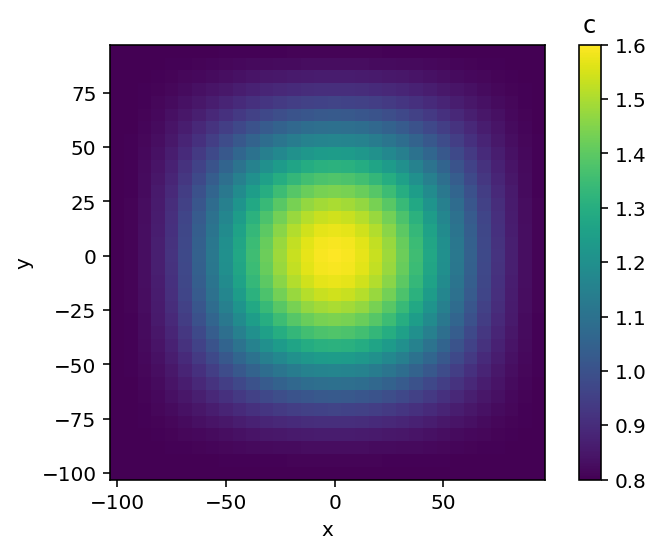

In [8]:
ax = plt.gca()
pcm = plt.pcolormesh(np.squeeze(x), np.squeeze(y), c["g"].T, cmap="viridis")#, vmin=0, vmax=0.2)
cb = plt.colorbar(pcm)
cb.ax.set_title("c")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")

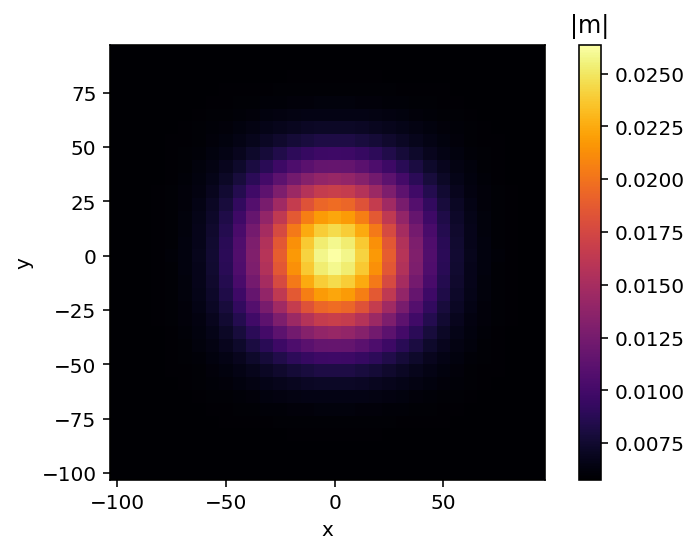

In [9]:
ax = plt.gca()
pcm = plt.pcolormesh(np.squeeze(x), np.squeeze(y), np.linalg.norm(m["g"], axis=(0,1)).T, cmap="inferno")
cb = plt.colorbar(pcm)
cb.ax.set_title("|m|")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")

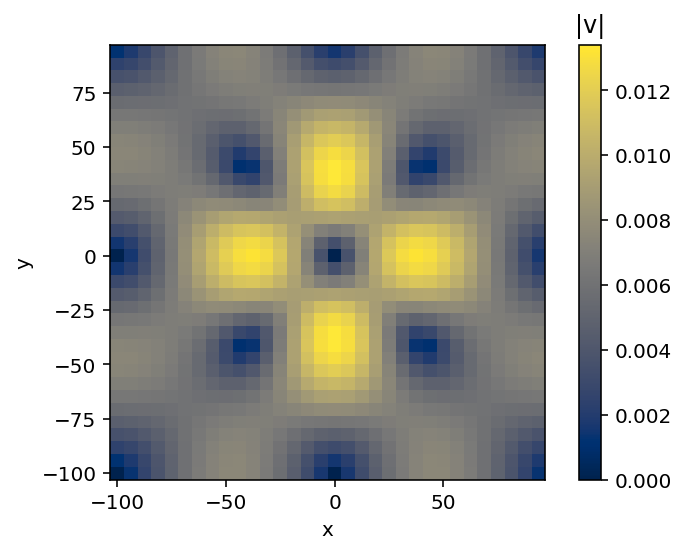

In [10]:
ax = plt.gca()
pcm = plt.pcolormesh(np.squeeze(x), np.squeeze(y), np.linalg.norm(v["g"], axis=0).T, cmap="cividis")#, vmin=0, vmax=1)
cb = plt.colorbar(pcm)
cb.ax.set_title("|v|")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")

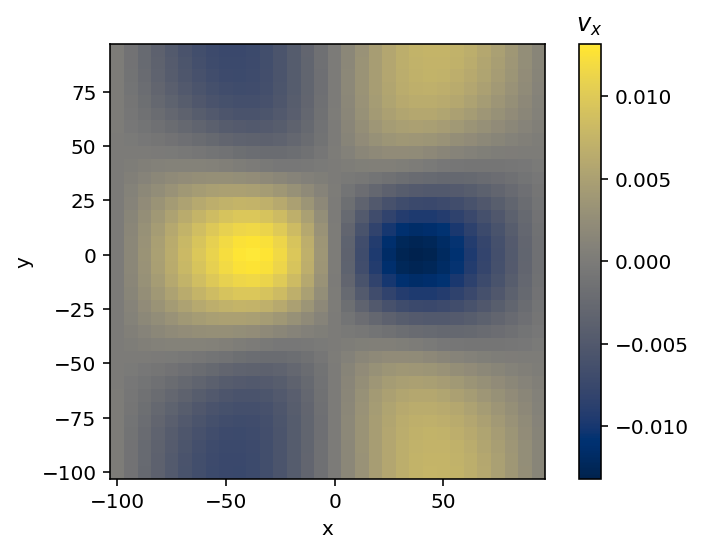

In [11]:
ax = plt.gca()
pcm = plt.pcolormesh(np.squeeze(x), np.squeeze(y), v["g"][0,:,:].T, cmap="cividis")
cb = plt.colorbar(pcm)
cb.ax.set_title(r"$v_x$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")

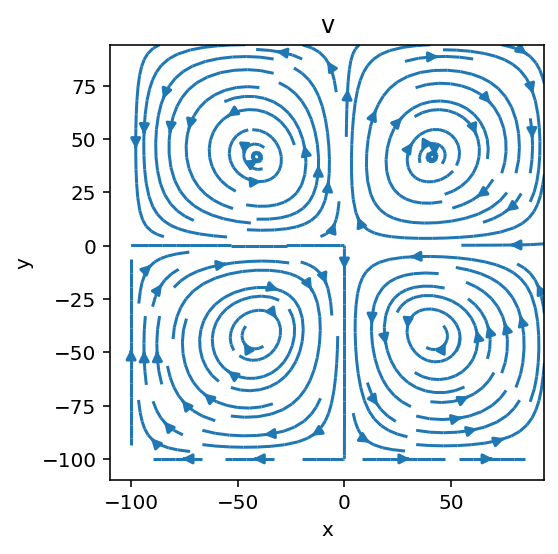

In [12]:
X, Y = np.meshgrid(x, y)
ax = plt.gca()
plt.streamplot(X, Y, v["g"][0,:,:].T,v["g"][1,:,:].T)
#plt.pcolormesh(np.squeeze(x), np.squeeze(y), np.linalg.norm(v["g"], axis=0).T)
#plt.streamplot(X, Y, v["g"][0,:,:].T,v["g"][1,:,:].T, color="white")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("v")
ax.set_aspect("equal")

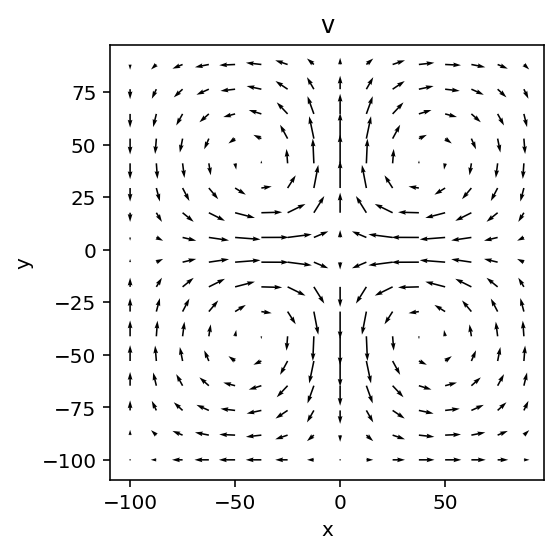

In [13]:
ax = plt.gca()
skip = 2
plt.quiver(X[::skip,::skip], Y[::skip,::skip], 
           v["g"][0,:,:].T[::skip,::skip],v["g"][1,:,:].T[::skip,::skip])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("v")
ax.set_aspect("equal")

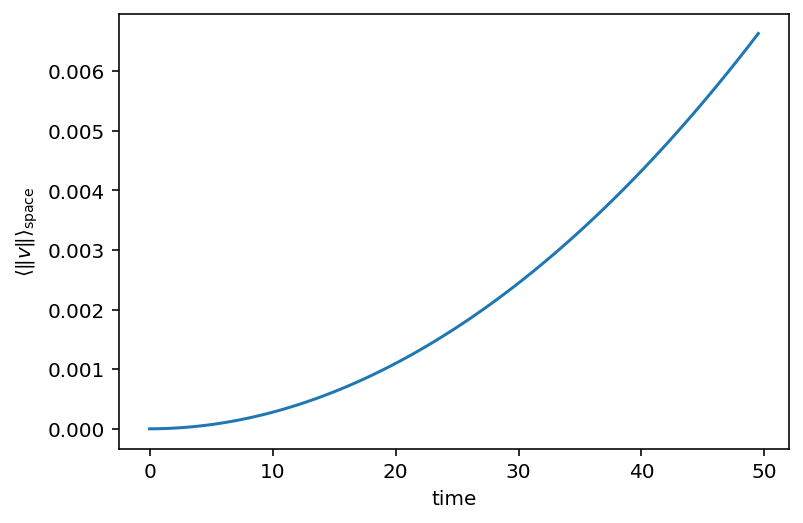

In [14]:
ax = plt.gca()
plt.plot(data["trajectory"]["t"], [np.mean(np.linalg.norm(v, axis=0)) for v in data["trajectory"]["v"]])
ax.set_xlabel("time")
ax.set_ylabel(r"$\langle|\!|v|\!|\rangle_{{\rm space}}$")
plt.show()

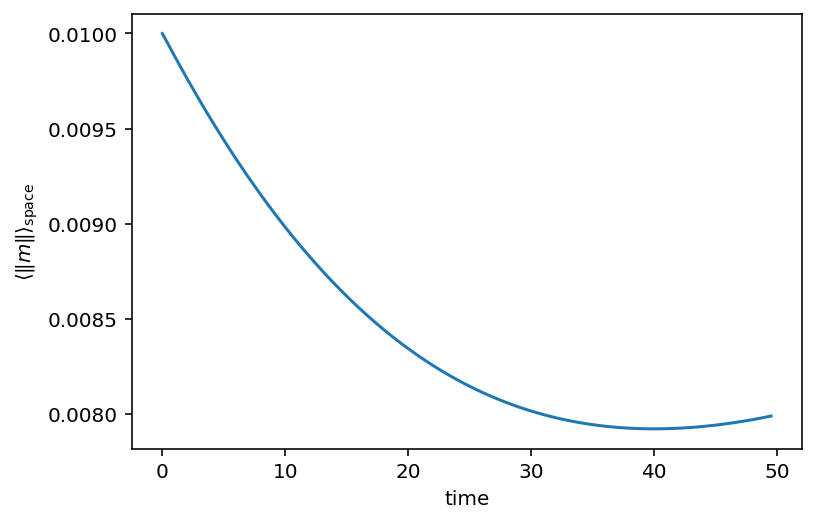

In [15]:
ax = plt.gca()
plt.plot(data["trajectory"]["t"], [np.mean(np.linalg.norm(m, axis=(0,1))) for m in data["trajectory"]["m"]])
ax.set_xlabel("time")
ax.set_ylabel(r"$\langle|\!|m|\!|\rangle_{{\rm space}}$")
plt.show()

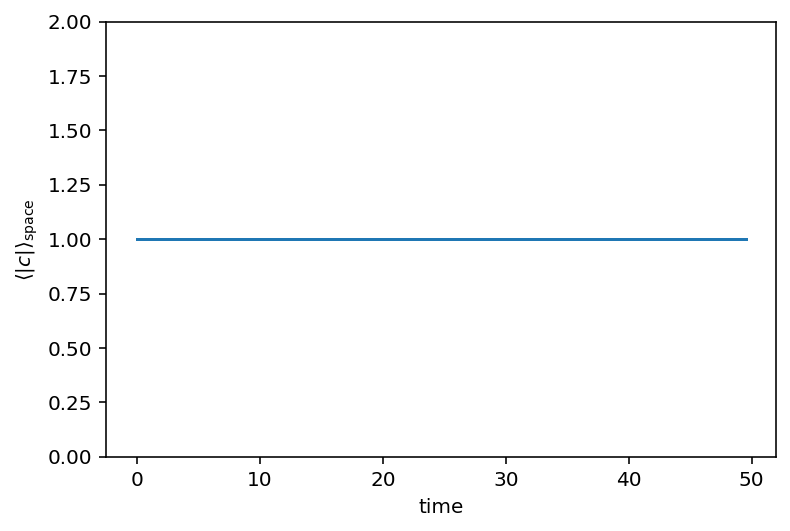

In [16]:
ax = plt.gca()
plt.plot(data["trajectory"]["t"], [np.mean(np.abs(c)) for c in data["trajectory"]["c"]])
ax.set_xlabel("time")
ax.set_ylabel(r"$\langle|c|\rangle_{{\rm space}}$")
ax.set_ylim(0,2)
plt.show()